<a href="https://colab.research.google.com/github/Antimon-Sb/FCHarDNet/blob/main/FCHarDNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm LabeledApproved_full.zip
!rm 701_StillsRaw_full.zip
!wget http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/data/LabeledApproved_full.zip
!wget http://web4.cs.ucl.ac.uk/staff/g.brostow/MotionSegRecData/files/701_StillsRaw_full.zip

--2022-04-29 19:24:50--  http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/data/LabeledApproved_full.zip
Resolving mi.eng.cam.ac.uk (mi.eng.cam.ac.uk)... 129.169.82.147
Connecting to mi.eng.cam.ac.uk (mi.eng.cam.ac.uk)|129.169.82.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16567585 (16M) [application/zip]
Saving to: ‘LabeledApproved_full.zip’

LabeledApproved_ful 100%[===================>]  15.80M  3.93MB/s    in 5.8s    

2022-04-29 19:24:57 (2.71 MB/s) - ‘LabeledApproved_full.zip’ saved [16567585/16567585]

--2022-04-29 19:24:57--  http://web4.cs.ucl.ac.uk/staff/g.brostow/MotionSegRecData/files/701_StillsRaw_full.zip
Resolving web4.cs.ucl.ac.uk (web4.cs.ucl.ac.uk)... 128.16.6.5
Connecting to web4.cs.ucl.ac.uk (web4.cs.ucl.ac.uk)|128.16.6.5|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 584553911 (557M) [application/zip]
Saving to: ‘701_StillsRaw_full.zip’

701_StillsRaw_full.   0%[                    ] 103.73K  65.4KB

In [7]:
!mkdir -p data/labeled
!mkdir -p data/raw
#!unzip LabeledApproved_full.zip -d /content/data/labeled
#!unzip /content/701_StillsRaw_full.zip -d /content/data/raw
!unzip drive/MyDrive/LabeledApproved_full.zip -d /content/data/labeled
!unzip drive/MyDrive/701_StillsRaw_full.zip -d /content/data/raw

Archive:  drive/MyDrive/LabeledApproved_full.zip
  inflating: /content/data/labeled/0001TP_006690_L.png  
  inflating: /content/data/labeled/0001TP_006720_L.png  
  inflating: /content/data/labeled/0001TP_006750_L.png  
  inflating: /content/data/labeled/0001TP_006780_L.png  
  inflating: /content/data/labeled/0001TP_006810_L.png  
  inflating: /content/data/labeled/0001TP_006840_L.png  
  inflating: /content/data/labeled/0001TP_006870_L.png  
  inflating: /content/data/labeled/0001TP_006900_L.png  
  inflating: /content/data/labeled/0001TP_006930_L.png  
  inflating: /content/data/labeled/0001TP_006960_L.png  
  inflating: /content/data/labeled/0001TP_006990_L.png  
  inflating: /content/data/labeled/0001TP_007020_L.png  
  inflating: /content/data/labeled/0001TP_007050_L.png  
  inflating: /content/data/labeled/0001TP_007080_L.png  
  inflating: /content/data/labeled/0001TP_007110_L.png  
  inflating: /content/data/labeled/0001TP_007140_L.png  
  inflating: /content/data/labeled/0001

(720, 960, 3)


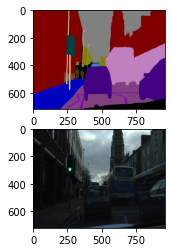

In [8]:
import matplotlib.pyplot as plt

imageL = plt.imread("/content/data/labeled/0001TP_006690_L.png")
image = plt.imread("/content/data/raw/701_StillsRaw_full/0001TP_006690.png")

plt.subplot(211)
plt.imshow(imageL)
plt.subplot(212)
plt.imshow(image)
print(image.shape)


In [9]:
#preparing data
import os
import numpy as np
import shutil
labeled_root = 'data/labeled'
raw_root = 'data/raw/701_StillsRaw_full'
#print(os.listdir(labeled_root))
for file in os.listdir(labeled_root):
    if file.find('_L') != -1:
      new_file = file[:file.find('_L')] + file[file.find('L') + 1:]
    #print(file)
      os.rename(labeled_root + '/' + file, labeled_root + '/' + new_file)
data_files = os.listdir(raw_root)
np.random.shuffle(data_files)
os.makedirs('data/test', exist_ok=True)
os.makedirs('data/train', exist_ok=True)
os.makedirs('data/val', exist_ok=True)
os.makedirs('data/test_L', exist_ok=True)
os.makedirs('data/train_L', exist_ok=True)
os.makedirs('data/val_L', exist_ok=True)
os.system('rm data/train/*')
os.system('rm data/test/*')
os.system('rm data/val/*')
train_filenames, testval = np.split(np.array(data_files), [int(len(data_files) * 0.8)])
test_filenames, val_filenames = np.split(np.array(testval), [int(len(testval) * 0.5)])

train_filenames_L = ['data/labeled/'+ name for name in train_filenames.tolist()]
train_filenames = ['data/raw/701_StillsRaw_full/'+ name for name in train_filenames.tolist()]
test_filenames_L = ['data/labeled/'+ name for name in test_filenames.tolist()]
test_filenames = ['data/raw/701_StillsRaw_full/' + name for name in test_filenames.tolist()]
val_filenames_L = ['data/labeled/'+ name for name in val_filenames.tolist()]
val_filenames = ['data/raw/701_StillsRaw_full/' + name for name in val_filenames.tolist()]

for filename in train_filenames:
    shutil.copy(filename, 'data/train')
for filename in test_filenames:
    shutil.copy(filename, 'data/test')
for filename in val_filenames:
    shutil.copy(filename, 'data/val')
for filename in train_filenames_L:
    shutil.copy(filename, 'data/train_L')
for filename in test_filenames_L:
    shutil.copy(filename, 'data/test_L')
for filename in val_filenames_L:
    shutil.copy(filename, 'data/val_L')
#print(len(os.listdir('data/train')), len(os.listdir('data/test')), len(os.listdir('data/val')))

In [73]:
import math
import numbers
import random
import torchvision.transforms.functional as tf

from PIL import Image, ImageOps


class Compose(object):
    def __init__(self, augmentations):
        self.augmentations = augmentations
        self.PIL2Numpy = False

    def __call__(self, img, mask):
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img, mode="RGB")
            mask = Image.fromarray(mask, mode="RGB")
            self.PIL2Numpy = True

        assert img.size == mask.size
        for a in self.augmentations:
            img, mask = a(img, mask)

        if self.PIL2Numpy:
            img, mask = np.array(img), np.array(mask, dtype=np.uint8)

        return img, mask

class RandomHorizontallyFlip(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img, mask):
        if random.random() < self.p:
            return (img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT))
        return img, mask

class RandomRotate(object):
    def __init__(self, degree):
        self.degree = degree

    def __call__(self, img, mask):
        rotate_degree = random.random() * 2 * self.degree - self.degree
        return (
            tf.affine(
                img,
                translate=(0, 0),
                scale=1.0,
                angle=rotate_degree,
                resample=Image.BILINEAR,
                fill=(0, 0, 0),
                shear=0.0,
            ),
            tf.affine(
                mask,
                translate=(0, 0),
                scale=1.0,
                angle=rotate_degree,
                resample=Image.NEAREST,
                fill=250,
                shear=0.0,
            ),
        )


In [103]:
from traitlets.traitlets import Long
#data loader
import collections
import torch
import numpy as np
import scipy.misc as m
import matplotlib.pyplot as plt
import skimage.transform
from torch.utils import data


def rgb_to_lbl(rgb):
    Sky = [128, 128, 128]
    Building = [128, 0, 0]
    Pole = [192, 192, 128]
    Road = [128, 64, 128]
    Pavement = [60, 40, 222]
    Tree = [128, 128, 0]
    SignSymbol = [192, 128, 128]
    Fence = [64, 64, 128]
    Car = [64, 0, 128]
    Pedestrian = [64, 64, 0]
    Bicyclist = [0, 128, 192]
    Unlabelled = [0, 0, 0]

    label_colours = np.array(
        [
            Sky,
            Building,
            Pole,
            Road,
            Pavement,
            Tree,
            SignSymbol,
            Fence,
            Car,
            Pedestrian,
            Bicyclist,
            Unlabelled,
        ]
    )
    label = 11 * torch.ones(720 * 960, dtype=torch.uint8)
    w, h, t = rgb.size()
    rgb2 = rgb[:]
    rgb = rgb.view(-1, t)
    for l in range(0, len(label_colours)):
      r = np.abs(rgb[:, 0]) == label_colours[l, 0]
      g = np.abs(rgb[:, 1]) == label_colours[l, 1]
      b = np.abs(rgb[:, 2]) == label_colours[l, 2]
      tf_rgb = r * g * b
      label[tf_rgb] = l
    label = label.reshape(720, 960)
    #print(rgb2[360][260:270], label[360][260:270])
    return label

class camvidLoader(data.Dataset):
    def __init__(
        self,
        root,
        split="train",
        is_transform=False,
        img_size=None,
        augmentations=None,
        img_norm=True,
        test_mode=False,
    ):
        self.root = root
        self.split = split
        self.img_size = [720, 960]
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.n_classes = 12
        self.files = collections.defaultdict(list)

        if not self.test_mode:
            for split in ["train", "test", "val"]:
                file_list = os.listdir(root + "/" + split)
                self.files[split] = file_list

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        img_name = self.files[self.split][index]
        img_path = self.root + "/" + self.split + "/" + img_name
        lbl_path = self.root + "/" + self.split + "_L/" + img_name

        img = plt.imread(img_path)
        img = np.array(img*255, dtype=np.uint8)

        lbl = plt.imread(lbl_path)
        lbl = np.array(lbl*255, dtype=np.int8)

        if self.augmentations is not None:
            img, lbl = self.augmentations(img, lbl)

        if self.is_transform:
            img, lbl = self.transform(img, lbl)
        return img, lbl

    def transform(self, img, lbl):
        img = skimage.transform.resize(img, (self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
        img = img * 255
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float64)
        img -= self.mean
        if self.img_norm:
            # Resize scales images from 0 to 255, thus we need
            # to divide by 255.0
            img = img.astype(float) / 255.0
        # NHWC -> NCHW
        img = img.transpose(2, 0, 1)

        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()
        return img, lbl

    def decode_segmap(self, temp, plot=False):
        Sky = [128, 128, 128]
        Building = [128, 0, 0]
        Pole = [192, 192, 128]
        Road = [128, 64, 128]
        Pavement = [60, 40, 222]
        Tree = [128, 128, 0]
        SignSymbol = [192, 128, 128]
        Fence = [64, 64, 128]
        Car = [64, 0, 128]
        Pedestrian = [64, 64, 0]
        Bicyclist = [0, 128, 192]
        Unlabelled = [0, 0, 0]

        label_colours = np.array(
            [
                Sky,
                Building,
                Pole,
                Road,
                Pavement,
                Tree,
                SignSymbol,
                Fence,
                Car,
                Pedestrian,
                Bicyclist,
                Unlabelled,
            ]
        )
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = label_colours[l, 0]
            g[temp == l] = label_colours[l, 1]
            b[temp == l] = label_colours[l, 2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:1132: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


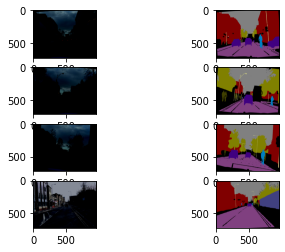

KeyboardInterrupt: ignored

In [104]:
#testing data loader
local_path = "data/"
#augmentations = Compose([RandomRotate(10), RandomHorizontallyFlip(0.5)])

dst = camvidLoader(local_path, is_transform=True, augmentations=augmentations)
bs = 4
trainloader = data.DataLoader(dst, batch_size=bs, shuffle=True)
for i, data_samples in enumerate(trainloader):
    imgs, labels = data_samples
    # print(imgs.size())
    imgs = imgs.numpy()[:, ::-1, :, :]
    imgs = np.transpose(imgs, [0, 2, 3, 1])
    newlabels=torch.zeros((len(labels), 720 , 960))
    # print(type(labels))
    for i in range(len(labels)):
      #print(labels[i,:,:,:].shape)
      # print(labels[i, :, :, :].size(), imgs.shape)
      newlabels[i] = rgb_to_lbl(labels[i,:,:,:])
    labels = newlabels
    f, axarr = plt.subplots(bs, 2)
    for j in range(bs):
        axarr[j][0].imshow(imgs[j])
        axarr[j][1].imshow(dst.decode_segmap(newlabels.numpy()[j]))
    plt.show()
    a = input()
    if a == "ex":
        break
    else:
        plt.close()

In [105]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import collections
#from CatConv2d.catconv2d import CatConv2d

class ConvLayer(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel=3, stride=1, dropout=0.1):
        super().__init__()
        self.add_module('conv', nn.Conv2d(in_channels, out_channels, kernel_size=kernel,
                                          stride=stride, padding=kernel//2, bias = False))
        self.add_module('norm', nn.BatchNorm2d(out_channels))
        self.add_module('relu', nn.ReLU(inplace=True))

        #print(kernel, 'x', kernel, 'x', in_channels, 'x', out_channels)

    def forward(self, x):
        return super().forward(x)
        

class BRLayer(nn.Sequential):
    def __init__(self, in_channels):
        super().__init__()
        
        self.add_module('norm', nn.BatchNorm2d(in_channels))
        self.add_module('relu', nn.ReLU(True))
    def forward(self, x):
        return super().forward(x)


class HarDBlock_v2(nn.Module):
    def get_link(self, layer, base_ch, growth_rate, grmul):
        if layer == 0:
          return base_ch, 0, []
        out_channels = growth_rate
        link = []
        for i in range(10):
          dv = 2 ** i
          if layer % dv == 0:
            k = layer - dv
            link.append(k)
            if i > 0:
                out_channels *= grmul
        out_channels = int(int(out_channels + 1) / 2) * 2
        in_channels = 0
        for i in link:
          ch,_,_ = self.get_link(i, base_ch, growth_rate, grmul)
          in_channels += ch
        return out_channels, in_channels, link


    def get_out_ch(self):
        return self.out_channels

    def __init__(self, in_channels, growth_rate, grmul, n_layers, keepBase=False, residual_out=False, dwconv=False, list_out=False):
        super().__init__()
        self.in_channels = in_channels
        self.growth_rate = growth_rate
        self.grmul = grmul
        self.n_layers = n_layers
        self.keepBase = keepBase
        self.links = []
        self.list_out = list_out
        layers_ = []
        self.out_channels = 0

        for i in range(n_layers):
          outch, inch, link = self.get_link(i+1, in_channels, growth_rate, grmul)
          self.links.append(link)
          use_relu = residual_out
          #layers_.append(CatConv2d(inch, outch, (3,3), relu=True))
          layers_.append(nn.Conv2d(inch, outch, (3,3), relu=True))

          if (i % 2 == 0) or (i == n_layers - 1):
            self.out_channels += outch
        print("Blk out =",self.out_channels)
        self.layers = nn.ModuleList(layers_)

    def transform(self, blk):
        for i in range(len(self.layers)):
            self.layers[i].weight[:,:,:,:] = blk.layers[i][0].weight[:,:,:,:]
            self.layers[i].bias[:] = blk.layers[i][0].bias[:]

    def forward(self, x):
        layers_ = [x]
        #self.res = []
        for layer in range(len(self.layers)):
            link = self.links[layer]
            tin = []
            for i in link:
                tin.append(layers_[i])

            out = self.layers[layer](tin)
            #self.res.append(out)
            layers_.append(out)
        t = len(layers_)
        out_ = []
        for i in range(t):
          if (i == 0 and self.keepBase) or \
             (i == t-1) or (i%2 == 1):
              out_.append(layers_[i])
        if self.list_out:
            return out_
        else:
            return torch.cat(out_, 1)



class HarDBlock(nn.Module):
    def get_link(self, layer, base_ch, growth_rate, grmul):
        if layer == 0:
          return base_ch, 0, []
        out_channels = growth_rate
        link = []
        for i in range(10):
          dv = 2 ** i
          if layer % dv == 0:
            k = layer - dv
            link.append(k)
            if i > 0:
                out_channels *= grmul
        out_channels = int(int(out_channels + 1) / 2) * 2
        in_channels = 0
        for i in link:
          ch,_,_ = self.get_link(i, base_ch, growth_rate, grmul)
          in_channels += ch
        return out_channels, in_channels, link

    def get_out_ch(self):
        return self.out_channels
 
    def __init__(self, in_channels, growth_rate, grmul, n_layers, keepBase=False, residual_out=False):
        super().__init__()
        self.in_channels = in_channels
        self.growth_rate = growth_rate
        self.grmul = grmul
        self.n_layers = n_layers
        self.keepBase = keepBase
        self.links = []
        layers_ = []
        self.out_channels = 0 # if upsample else in_channels
        for i in range(n_layers):
          outch, inch, link = self.get_link(i+1, in_channels, growth_rate, grmul)
          self.links.append(link)
          use_relu = residual_out
          layers_.append(ConvLayer(inch, outch))
          if (i % 2 == 0) or (i == n_layers - 1):
            self.out_channels += outch
        #print("Blk out =",self.out_channels)
        self.layers = nn.ModuleList(layers_)


    def forward(self, x):
        layers_ = [x]
        for layer in range(len(self.layers)):
            link = self.links[layer]
            tin = []
            for i in link:
                tin.append(layers_[i])
            if len(tin) > 1:
                x = torch.cat(tin, 1)
            else:
                x = tin[0]
            out = self.layers[layer](x)
            layers_.append(out)
        t = len(layers_)
        out_ = []
        for i in range(t):
          if (i == 0 and self.keepBase) or \
             (i == t-1) or (i%2 == 1):
              out_.append(layers_[i])
        out = torch.cat(out_, 1)
        return out



class TransitionUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        #print("upsample",in_channels, out_channels)

    def forward(self, x, skip, concat=True):
        is_v2 = type(skip) is list
        if is_v2:
            skip_x = skip[0]
        else:
            skip_x = skip
        out = F.interpolate(
                x,
                size=(skip_x.size(2), skip_x.size(3)),
                mode="bilinear",
                align_corners=True,
                            )
        if concat:       
          if is_v2:
            out = [out] + skip
          else:                     
            out = torch.cat([out, skip], 1)
          
        return out

class hardnet(nn.Module):
    def __init__(self, n_classes=12):
        super(hardnet, self).__init__()

        first_ch  = [16,24,32,48]
        ch_list = [  64, 96, 160, 224, 320]
        grmul = 1.7
        gr       = [  10,16,18,24,32]
        n_layers = [   4, 4, 8, 8, 8]

        blks = len(n_layers) 
        self.shortcut_layers = []

        self.base = nn.ModuleList([])
        self.base.append (
             ConvLayer(in_channels=3, out_channels=first_ch[0], kernel=3,
                       stride=2) )
        self.base.append ( ConvLayer(first_ch[0], first_ch[1],  kernel=3) )
        self.base.append ( ConvLayer(first_ch[1], first_ch[2],  kernel=3, stride=2) )
        self.base.append ( ConvLayer(first_ch[2], first_ch[3],  kernel=3) )

        skip_connection_channel_counts = []
        ch = first_ch[3]
        for i in range(blks):
            blk = HarDBlock(ch, gr[i], grmul, n_layers[i])
            ch = blk.get_out_ch()
            skip_connection_channel_counts.append(ch)
            self.base.append ( blk )
            if i < blks-1:
              self.shortcut_layers.append(len(self.base)-1)

            self.base.append ( ConvLayer(ch, ch_list[i], kernel=1) )
            ch = ch_list[i]
            
            if i < blks-1:            
              self.base.append ( nn.AvgPool2d(kernel_size=2, stride=2) )


        cur_channels_count = ch
        prev_block_channels = ch
        n_blocks = blks-1
        self.n_blocks =  n_blocks

        # upsampling

        self.transUpBlocks = nn.ModuleList([])
        self.denseBlocksUp = nn.ModuleList([])
        self.conv1x1_up    = nn.ModuleList([])
        
        for i in range(n_blocks-1,-1,-1):
            self.transUpBlocks.append(TransitionUp(prev_block_channels, prev_block_channels))
            cur_channels_count = prev_block_channels + skip_connection_channel_counts[i]
            self.conv1x1_up.append(ConvLayer(cur_channels_count, cur_channels_count//2, kernel=1))
            cur_channels_count = cur_channels_count//2

            blk = HarDBlock(cur_channels_count, gr[i], grmul, n_layers[i])
            
            self.denseBlocksUp.append(blk)
            prev_block_channels = blk.get_out_ch()
            cur_channels_count = prev_block_channels


        self.finalConv = nn.Conv2d(in_channels=cur_channels_count,
               out_channels=n_classes, kernel_size=1, stride=1,
               padding=0, bias=True)
    
    def v2_transform(self):        
        for i in range( len(self.base)):
            if isinstance(self.base[i], HarDBlock):
                blk = self.base[i]
                self.base[i] = HarDBlock_v2(blk.in_channels, blk.growth_rate, blk.grmul, blk.n_layers, list_out=True)
                self.base[i].transform(blk)
            elif isinstance(self.base[i], nn.Sequential):
                blk = self.base[i]
                sz = blk[0].weight.shape
                if sz[2] == 1:
                    #self.base[i] = CatConv2d(sz[1],sz[0],(1,1), relu=True)
                    self.base[i] = nn.Conv2d(sz[1],sz[0],(1,1), relu=True)
                    self.base[i].weight[:,:,:,:] = blk[0].weight[:,:,:,:]
                    self.base[i].bias[:] = blk[0].bias[:]

        for i in range(self.n_blocks):
            blk = self.denseBlocksUp[i]
            self.denseBlocksUp[i] = HarDBlock_v2(blk.in_channels, blk.growth_rate, blk.grmul, blk.n_layers, list_out=False)
            self.denseBlocksUp[i].transform(blk)
  
        for i in range(len(self.conv1x1_up)):
            blk = self.conv1x1_up[i]
            sz = blk[0].weight.shape
            if sz[2] == 1:
                #self.conv1x1_up[i] = CatConv2d(sz[1],sz[0],(1,1), relu=True)
                self.conv1x1_up[i] = nn.Conv2d(sz[1],sz[0],(1,1), relu=True)
                self.conv1x1_up[i].weight[:,:,:,:] = blk[0].weight[:,:,:,:]
                self.conv1x1_up[i].bias[:] = blk[0].bias[:]                 

    def forward(self, x):
        
        skip_connections = []
        size_in = x.size()
        
        
        for i in range(len(self.base)):
            x = self.base[i](x)
            if i in self.shortcut_layers:
                skip_connections.append(x)
        out = x
        
        for i in range(self.n_blocks):
            skip = skip_connections.pop()
            out = self.transUpBlocks[i](out, skip, True)
            out = self.conv1x1_up[i](out)
            out = self.denseBlocksUp[i](out)
        
        out = self.finalConv(out)
        
        out = F.interpolate(
                            out,
                            size=(size_in[2], size_in[3]),
                            mode="bilinear",
                            align_corners=True)
        return out

In [106]:
class runningScore(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def _fast_hist(self, label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask], minlength=n_class ** 2
        ).reshape(n_class, n_class)
        return hist

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist(lt.flatten(), lp.flatten(), self.n_classes)

    def get_scores(self):
        """Returns accuracy score evaluation result.
            - overall accuracy
            - mean accuracy
            - mean IU
            - fwavacc
        """
        hist = self.confusion_matrix
        acc = np.diag(hist).sum() / hist.sum()
        acc_cls = np.diag(hist) / hist.sum(axis=1)
        acc_cls = np.nanmean(acc_cls)
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu)
        freq = hist.sum(axis=1) / hist.sum()
        fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
        cls_iu = dict(zip(range(self.n_classes), iu))

        return (
            {
                "Overall Acc: \t": acc,
                "Mean Acc : \t": acc_cls,
                "FreqW Acc : \t": fwavacc,
                "Mean IoU : \t": mean_iu,
            },
            cls_iu,
        )

    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))


class averageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [21]:
def cross_entropy2d(input, target, weight=None, size_average=True):
    n, c, h, w = input.size()
    nt, ht, wt = target.size()
    #print(input.size(), target.size())
    #nt, ht, wt = target.size()

    if h != ht and w != wt:  # upsample labels
        input = F.interpolate(input, size=(ht, wt), mode="bilinear", align_corners=True)

    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    target = target.view(-1)
    #print(input.size(), target.size())
    #print(input[0, 0].dtype, target[0].dtype)
    loss = F.cross_entropy(
              input, target, weight=weight, size_average=size_average, ignore_index=250, reduction='mean')

    return loss


In [108]:
import time
from tqdm import tqdm

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)


# Setup seeds
torch.manual_seed(1337)
torch.cuda.manual_seed(1337)
np.random.seed(1337)
random.seed(1337)

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup Augmentations
#augmentations = cfg["training"].get("augmentations", None)
#data_aug = get_composed_augmentations(augmentations)
data_aug = Compose([RandomRotate(10), RandomHorizontallyFlip(0.5)])

# Setup Dataloader

#data_loader = get_loader(cfg["data"]["dataset"])
data_loader = camvidLoader
#data_path = cfg["data"]["path"]
data_path = 'data/'

t_loader = data_loader(
    data_path,
    is_transform=True,
    #split=cfg["data"]["train_split"],
    split='train',
    #img_size=(cfg["data"]["img_rows"], cfg["data"]["img_cols"]),
    img_size=(720, 960),
    augmentations=data_aug,
)

v_loader = data_loader(
    data_path,
    is_transform=True,
    #split=cfg["data"]["val_split"],
    split='val',
    img_size=(720,960),
)

n_classes = t_loader.n_classes
trainloader = data.DataLoader(
    t_loader,
    #batch_size=cfg["training"]["batch_size"],
    batch_size=4,
    #num_workers=cfg["training"]["n_workers"],
    shuffle=True,
)

valloader = data.DataLoader(
    v_loader, 
    #batch_size=cfg["training"]["batch_size"],
    batch_size=4, 
    #num_workers=cfg["training"]["n_workers"]
)

# Setup Metrics
running_metrics_val = runningScore(n_classes)

# Setup Model

#model = get_model(cfg["model"], n_classes).to(device)
model = hardnet()

total_params = sum(p.numel() for p in model.parameters())
print( 'Parameters:',total_params )

model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
model.apply(weights_init)
#pretrained_path='weights/hardnet_petite_base.pth'
#weights = torch.load(pretrained_path)
#model.module.base.load_state_dict(weights)

# Setup optimizer, lr_scheduler and loss function
#optimizer_cls = get_optimizer(cfg)
optimizer_cls = torch.optim.SGD
#optimizer_params = {k: v for k, v in cfg["training"]["optimizer"].items() if k != "name"}

optimizer = optimizer_cls(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
print("Using optimizer {}".format(optimizer))

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

#loss_fn = get_loss_function(cfg)
loss_fn = cross_entropy2d
print("Using loss {}".format(loss_fn))

start_iter = 0
# if cfg["training"]["resume"] is not None:
#     if os.path.isfile(cfg["training"]["resume"]):
#         logger.info(
#             "Loading model and optimizer from checkpoint '{}'".format(cfg["training"]["resume"])
#         )
#         checkpoint = torch.load(cfg["training"]["resume"])
#         model.load_state_dict(checkpoint["model_state"])
#         optimizer.load_state_dict(checkpoint["optimizer_state"])
#         scheduler.load_state_dict(checkpoint["scheduler_state"])
#         start_iter = checkpoint["epoch"]
#         logger.info(
#             "Loaded checkpoint '{}' (iter {})".format(
#                 cfg["training"]["resume"], checkpoint["epoch"]
#             )
#         )
#     else:
#         logger.info("No checkpoint found at '{}'".format(cfg["training"]["resume"]))

# if cfg["training"]["finetune"] is not None:
#     if os.path.isfile(cfg["training"]["finetune"]):
#         logger.info(
#             "Loading model and optimizer from checkpoint '{}'".format(cfg["training"]["finetune"])
#         )
#         checkpoint = torch.load(cfg["training"]["finetune"])
#         model.load_state_dict(checkpoint["model_state"])

val_loss_meter = averageMeter()
time_meter = averageMeter()

best_iou = -100.0
flag = True
loss_all = 0
loss_n = 0
epoch = 0
num_epochs = 10
per_epoch = 200
train_iters = 2000
i = start_iter
#while i <= cfg["training"]["train_iters"] and flag:
while i <= train_iters and flag:
    for (images, labels) in trainloader:
        i += 1
        start_ts = time.time()
        model.train()
        images = images.to(device)
        newlabels = torch.zeros((len(labels), 720, 960))
        for j in range(len(labels)):
          newlabels[j] = rgb_to_lbl(labels[j, :, :, :])
        labels = newlabels
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        #print(images.size(), outputs.size(), labels.size())

        #print(labels.size())
        # print(labels.count_nonzero(), labels.size())
        loss = loss_fn(input=outputs, target=labels.long())
        loss.backward()
        optimizer.step()
        c_lr = scheduler.get_last_lr()

        time_meter.update(time.time() - start_ts)
        loss_all += loss.item()
        loss_n += 1
        
        #if (i + 1) % cfg["training"]["print_interval"] == 0:
        if (i + 1) % per_epoch == 0:
          epoch = epoch + 1
          scheduler.step()
        if (i + 1) % 10 == 0:
            fmt_str = "Epoch {:d} Iter [{:d}/{:d}]  Loss: {:.4f}  Time/Image: {:.4f}  lr={:.6f}"
            print_str = fmt_str.format(
                epoch,
                (i + 1) % (train_iters // num_epochs),
                #cfg["training"]["train_iters"],
                train_iters // num_epochs,
                loss_all / loss_n,
                #time_meter.avg / cfg["training"]["batch_size"],
                time_meter.avg / 4,
                c_lr[0],
            )
            

            print(print_str)
            #logger.info(print_str)
            #writer.add_scalar("loss/train_loss", loss.item(), i + 1)
            time_meter.reset()

        # if (i + 1) % cfg["training"]["val_interval"] == 0 or (i + 1) == cfg["training"][
        #     "train_iters"
        # ]:
        #print(i + 1)
        if (i + 1) % per_epoch == 0 or (i + 1) == train_iters:
          torch.cuda.empty_cache()
          model.eval()
          loss_all = 0
          loss_n = 0
          with torch.no_grad():
              for i_val, (images_val, labels_val) in tqdm(enumerate(valloader)):
                  images_val = images_val.to(device)
                  newlabels = torch.zeros((len(labels_val), 720, 960))
                  for j in range(len(labels_val)):
                    newlabels[j] = rgb_to_lbl(labels_val[j, :, :, :])
                  labels_val = newlabels
                  labels_val = labels_val.to(device)

                  outputs = model(images_val)
                  val_loss = loss_fn(input=outputs, target=labels_val.long())

                  pred = outputs.data.max(1)[1].cpu().numpy()
                  gt = labels_val.data.cpu().numpy()

                  running_metrics_val.update(gt, pred)
                  val_loss_meter.update(val_loss.item())

          #writer.add_scalar("loss/val_loss", val_loss_meter.avg, i + 1)
          #logger.info("Iter %d Val Loss: %.4f" % (i + 1, val_loss_meter.avg))
          print(format("Epoch %d Iter %d Val Loss: %.4f" % (epoch, i + 1, val_loss_meter.avg)))

          score, class_iou = running_metrics_val.get_scores()
          for k, v in score.items():
              print(k, v)
              #logger.info("{}: {}".format(k, v))
              #writer.add_scalar("val_metrics/{}".format(k), v, i + 1)

          #for k, v in class_iou.items():
              #logger.info("{}: {}".format(k, v))
              #writer.add_scalar("val_metrics/cls_{}".format(k), v, i + 1)

          val_loss_meter.reset()
          running_metrics_val.reset()
          
          state = {
                "epoch": i + 1,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scheduler_state": scheduler.state_dict(),
          }
          # save_path = os.path.join(
          #     writer.file_writer.get_logdir(),
          #     "{}_{}_checkpoint.pkl".format(cfg["model"]["arch"], cfg["data"]["dataset"]),
          # )
          # torch.save(state, save_path)

          if score["Mean IoU : \t"] >= best_iou:
              best_iou = score["Mean IoU : \t"]
              state = {
                  "epoch": i + 1,
                  "model_state": model.state_dict(),
                  "best_iou": best_iou,
              }
              # save_path = os.path.join(
              #     writer.file_writer.get_logdir(),
              #     "{}_{}_best_model.pkl".format(cfg["model"]["arch"], cfg["data"]["dataset"]),
              # )
              # torch.save(state, save_path)
          torch.cuda.empty_cache()
      
          # if (i + 1) == cfg["training"]["train_iters"]:
    if (i + 1) == 90000:
        flag = False
        break

Parameters: 4118914
Using optimizer SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
)
Using loss <function cross_entropy2d at 0x7f1b037f2710>


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:1132: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. "
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch 0 Iter [10/100]  Loss: 1.8207  Time/Image: 2.4784  lr=0.100000
Epoch 0 Iter [20/100]  Loss: 1.5023  Time/Image: 2.4579  lr=0.100000
Epoch 0 Iter [30/100]  Loss: 1.3984  Time/Image: 2.4611  lr=0.100000
Epoch 0 Iter [40/100]  Loss: 1.3121  Time/Image: 2.5257  lr=0.100000
Epoch 0 Iter [50/100]  Loss: 1.2591  Time/Image: 2.4545  lr=0.100000
Epoch 0 Iter [60/100]  Loss: 1.2159  Time/Image: 2.4509  lr=0.100000
Epoch 0 Iter [70/100]  Loss: 1.1788  Time/Image: 2.4423  lr=0.100000
Epoch 0 Iter [80/100]  Loss: 1.1525  Time/Image: 2.4562  lr=0.100000
Epoch 0 Iter [90/100]  Loss: 1.1289  Time/Image: 2.4405  lr=0.100000
Epoch 1 Iter [0/100]  Loss: 1.1132  Time/Image: 2.4368  lr=0.100000


18it [01:23,  4.65s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Epoch 1 Iter 100 Val Loss: 0.9728
Overall Acc: 	 0.6345485703573291
Mean Acc : 	 0.3773381916211499
FreqW Acc : 	 0.46355850414288957
Mean IoU : 	 0.2743992698622338
Epoch 1 Iter [10/100]  Loss: 0.9304  Time/Image: 2.4333  lr=0.050000
Epoch 1 Iter [20/100]  Loss: 0.8965  Time/Image: 2.4250  lr=0.050000
Epoch 1 Iter [30/100]  Loss: 0.8860  Time/Image: 2.4259  lr=0.050000
Epoch 1 Iter [40/100]  Loss: 0.8990  Time/Image: 2.4187  lr=0.050000
Epoch 1 Iter [50/100]  Loss: 0.8942  Time/Image: 2.4070  lr=0.050000
Epoch 1 Iter [60/100]  Loss: 0.8876  Time/Image: 2.4163  lr=0.050000
Epoch 1 Iter [70/100]  Loss: 0.8844  Time/Image: 2.5175  lr=0.050000
Epoch 1 Iter [80/100]  Loss: 0.8759  Time/Image: 2.4235  lr=0.050000
Epoch 1 Iter [90/100]  Loss: 0.8705  Time/Image: 2.4199  lr=0.050000
Epoch 2 Iter [0/100]  Loss: 0.8653  Time/Image: 2.4288  lr=0.050000


18it [01:21,  4.54s/it]


Epoch 2 Iter 200 Val Loss: 1.0189
Overall Acc: 	 0.6222748557316119
Mean Acc : 	 0.4355760556905455
FreqW Acc : 	 0.4728169512166409
Mean IoU : 	 0.3164234497703723
Epoch 2 Iter [10/100]  Loss: 0.7667  Time/Image: 2.4144  lr=0.025000
Epoch 2 Iter [20/100]  Loss: 0.7699  Time/Image: 2.5192  lr=0.025000
Epoch 2 Iter [30/100]  Loss: 0.8091  Time/Image: 2.4486  lr=0.025000
Epoch 2 Iter [40/100]  Loss: 0.8213  Time/Image: 2.4475  lr=0.025000
Epoch 2 Iter [50/100]  Loss: 0.8119  Time/Image: 2.4462  lr=0.025000
Epoch 2 Iter [60/100]  Loss: 0.8114  Time/Image: 2.4427  lr=0.025000
Epoch 2 Iter [70/100]  Loss: 0.8022  Time/Image: 2.4421  lr=0.025000
Epoch 2 Iter [80/100]  Loss: 0.7962  Time/Image: 2.4411  lr=0.025000
Epoch 2 Iter [90/100]  Loss: 0.7868  Time/Image: 2.4443  lr=0.025000
Epoch 3 Iter [0/100]  Loss: 0.7818  Time/Image: 2.4433  lr=0.025000


18it [01:23,  4.62s/it]


Epoch 3 Iter 300 Val Loss: 0.7833
Overall Acc: 	 0.7243008281168493
Mean Acc : 	 0.5151683083191397
FreqW Acc : 	 0.5795565976080395
Mean IoU : 	 0.40843286436255977
Epoch 3 Iter [10/100]  Loss: 0.7906  Time/Image: 2.4399  lr=0.012500
Epoch 3 Iter [20/100]  Loss: 0.7464  Time/Image: 2.4529  lr=0.012500
Epoch 3 Iter [30/100]  Loss: 0.7249  Time/Image: 2.5095  lr=0.012500
Epoch 3 Iter [40/100]  Loss: 0.7287  Time/Image: 2.4741  lr=0.012500
Epoch 3 Iter [50/100]  Loss: 0.7210  Time/Image: 2.4657  lr=0.012500
Epoch 3 Iter [60/100]  Loss: 0.7201  Time/Image: 2.4553  lr=0.012500
Epoch 3 Iter [70/100]  Loss: 0.7147  Time/Image: 2.4431  lr=0.012500
Epoch 3 Iter [80/100]  Loss: 0.7157  Time/Image: 2.4439  lr=0.012500
Epoch 3 Iter [90/100]  Loss: 0.7156  Time/Image: 2.4295  lr=0.012500
Epoch 4 Iter [0/100]  Loss: 0.7102  Time/Image: 2.4335  lr=0.012500


18it [01:22,  4.60s/it]


Epoch 4 Iter 400 Val Loss: 0.7351
Overall Acc: 	 0.7516860654668753
Mean Acc : 	 0.5478513395290026
FreqW Acc : 	 0.6127915312795584
Mean IoU : 	 0.4401749083521877
Epoch 4 Iter [10/100]  Loss: 0.6158  Time/Image: 2.4298  lr=0.006250
Epoch 4 Iter [20/100]  Loss: 0.6367  Time/Image: 2.4282  lr=0.006250
Epoch 4 Iter [30/100]  Loss: 0.6485  Time/Image: 2.4265  lr=0.006250
Epoch 4 Iter [40/100]  Loss: 0.6494  Time/Image: 2.4137  lr=0.006250
Epoch 4 Iter [50/100]  Loss: 0.6561  Time/Image: 2.4097  lr=0.006250
Epoch 4 Iter [60/100]  Loss: 0.6493  Time/Image: 2.4082  lr=0.006250
Epoch 4 Iter [70/100]  Loss: 0.6465  Time/Image: 2.4149  lr=0.006250
Epoch 4 Iter [80/100]  Loss: 0.6451  Time/Image: 2.4182  lr=0.006250
Epoch 4 Iter [90/100]  Loss: 0.6442  Time/Image: 2.3943  lr=0.006250
Epoch 5 Iter [0/100]  Loss: 0.6452  Time/Image: 2.3991  lr=0.006250


18it [01:20,  4.49s/it]


Epoch 5 Iter 500 Val Loss: 0.6769
Overall Acc: 	 0.774119005118675
Mean Acc : 	 0.5787546626881355
FreqW Acc : 	 0.644308747176457
Mean IoU : 	 0.47270997189493963
Epoch 5 Iter [10/100]  Loss: 0.6372  Time/Image: 2.5234  lr=0.003125
Epoch 5 Iter [20/100]  Loss: 0.6346  Time/Image: 2.4390  lr=0.003125
Epoch 5 Iter [30/100]  Loss: 0.6407  Time/Image: 2.4306  lr=0.003125
Epoch 5 Iter [40/100]  Loss: 0.6348  Time/Image: 2.4223  lr=0.003125
Epoch 5 Iter [50/100]  Loss: 0.6338  Time/Image: 2.4163  lr=0.003125
Epoch 5 Iter [60/100]  Loss: 0.6250  Time/Image: 2.4100  lr=0.003125
Epoch 5 Iter [70/100]  Loss: 0.6219  Time/Image: 2.4148  lr=0.003125
Epoch 5 Iter [80/100]  Loss: 0.6250  Time/Image: 2.4025  lr=0.003125
Epoch 5 Iter [90/100]  Loss: 0.6259  Time/Image: 2.4069  lr=0.003125
Epoch 6 Iter [0/100]  Loss: 0.6234  Time/Image: 2.4061  lr=0.003125


18it [01:21,  4.52s/it]


Epoch 6 Iter 600 Val Loss: 0.6730
Overall Acc: 	 0.7791694175469484
Mean Acc : 	 0.5815055363519472
FreqW Acc : 	 0.6516446742413634
Mean IoU : 	 0.4763048366075632
Epoch 6 Iter [10/100]  Loss: 0.6290  Time/Image: 2.4021  lr=0.001563
Epoch 6 Iter [20/100]  Loss: 0.6043  Time/Image: 2.4044  lr=0.001563
Epoch 6 Iter [30/100]  Loss: 0.6019  Time/Image: 2.4024  lr=0.001563
Epoch 6 Iter [40/100]  Loss: 0.6072  Time/Image: 2.4064  lr=0.001563
Epoch 6 Iter [50/100]  Loss: 0.6173  Time/Image: 2.4054  lr=0.001563
Epoch 6 Iter [60/100]  Loss: 0.6102  Time/Image: 2.3956  lr=0.001563
Epoch 6 Iter [70/100]  Loss: 0.6087  Time/Image: 2.3913  lr=0.001563
Epoch 6 Iter [80/100]  Loss: 0.6059  Time/Image: 2.3954  lr=0.001563
Epoch 6 Iter [90/100]  Loss: 0.6037  Time/Image: 2.3939  lr=0.001563
Epoch 7 Iter [0/100]  Loss: 0.6051  Time/Image: 2.5090  lr=0.001563


18it [01:22,  4.60s/it]


Epoch 7 Iter 700 Val Loss: 0.6481
Overall Acc: 	 0.789150609676578
Mean Acc : 	 0.592767537681298
FreqW Acc : 	 0.6639414025558772
Mean IoU : 	 0.485854099753789
Epoch 7 Iter [10/100]  Loss: 0.5716  Time/Image: 2.4312  lr=0.000781
Epoch 7 Iter [20/100]  Loss: 0.5824  Time/Image: 2.4339  lr=0.000781
Epoch 7 Iter [30/100]  Loss: 0.5944  Time/Image: 2.4319  lr=0.000781
Epoch 7 Iter [40/100]  Loss: 0.5855  Time/Image: 2.4248  lr=0.000781
Epoch 7 Iter [50/100]  Loss: 0.5791  Time/Image: 2.4181  lr=0.000781
Epoch 7 Iter [60/100]  Loss: 0.5865  Time/Image: 2.4140  lr=0.000781
Epoch 7 Iter [70/100]  Loss: 0.5918  Time/Image: 2.4179  lr=0.000781
Epoch 7 Iter [80/100]  Loss: 0.5914  Time/Image: 2.4213  lr=0.000781
Epoch 7 Iter [90/100]  Loss: 0.5965  Time/Image: 2.4114  lr=0.000781
Epoch 8 Iter [0/100]  Loss: 0.5975  Time/Image: 2.4026  lr=0.000781


18it [01:21,  4.53s/it]


Epoch 8 Iter 800 Val Loss: 0.6465
Overall Acc: 	 0.7912087164188837
Mean Acc : 	 0.5905320683187504
FreqW Acc : 	 0.667640882127459
Mean IoU : 	 0.4863786208212329
Epoch 8 Iter [10/100]  Loss: 0.5955  Time/Image: 2.3934  lr=0.000391
Epoch 8 Iter [20/100]  Loss: 0.6041  Time/Image: 2.3943  lr=0.000391
Epoch 8 Iter [30/100]  Loss: 0.6099  Time/Image: 2.3935  lr=0.000391
Epoch 8 Iter [40/100]  Loss: 0.6124  Time/Image: 2.3906  lr=0.000391
Epoch 8 Iter [50/100]  Loss: 0.6047  Time/Image: 2.3906  lr=0.000391
Epoch 8 Iter [70/100]  Loss: 0.5990  Time/Image: 2.3901  lr=0.000391
Epoch 8 Iter [80/100]  Loss: 0.5985  Time/Image: 2.3888  lr=0.000391
Epoch 8 Iter [90/100]  Loss: 0.5990  Time/Image: 2.3889  lr=0.000391
Epoch 9 Iter [0/100]  Loss: 0.5986  Time/Image: 2.4223  lr=0.000391


18it [01:21,  4.54s/it]


Epoch 9 Iter 900 Val Loss: 0.6349
Overall Acc: 	 0.795669890290819
Mean Acc : 	 0.5923947713613976
FreqW Acc : 	 0.671391714213898
Mean IoU : 	 0.4910015155930586
Epoch 9 Iter [10/100]  Loss: 0.5825  Time/Image: 2.4190  lr=0.000195
Epoch 9 Iter [20/100]  Loss: 0.5990  Time/Image: 2.4209  lr=0.000195
Epoch 9 Iter [30/100]  Loss: 0.6067  Time/Image: 2.4258  lr=0.000195
Epoch 9 Iter [40/100]  Loss: 0.6028  Time/Image: 2.4288  lr=0.000195
Epoch 9 Iter [50/100]  Loss: 0.6041  Time/Image: 2.4159  lr=0.000195
Epoch 9 Iter [60/100]  Loss: 0.6010  Time/Image: 2.4158  lr=0.000195
Epoch 9 Iter [70/100]  Loss: 0.6005  Time/Image: 2.4164  lr=0.000195
Epoch 9 Iter [80/100]  Loss: 0.5987  Time/Image: 2.4203  lr=0.000195
Epoch 9 Iter [90/100]  Loss: 0.5976  Time/Image: 2.4203  lr=0.000195
Epoch 10 Iter [0/100]  Loss: 0.5984  Time/Image: 2.4060  lr=0.000195


18it [01:21,  4.51s/it]


Epoch 10 Iter 1000 Val Loss: 0.6365
Overall Acc: 	 0.7948272854720918
Mean Acc : 	 0.591980630906924
FreqW Acc : 	 0.6710754558820888
Mean IoU : 	 0.48997835455654937
Epoch 10 Iter [10/100]  Loss: 0.5821  Time/Image: 2.4206  lr=0.000098


KeyboardInterrupt: ignored